# Dataset

https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/medical_insurance_dataset.csv

|Parameter|Description|Content Type|
|-------- |------- |--------|
|Age|Age of the insured|Integer|
|Gender|Gender of the insured|Integer(Female 1,Male 2)|
|BMI|Body Mass Index of the insured|Float|
|No_of_Children|Number of children the insured person has|Integer|
|Smoker|Whether the insured person is a smoker or not|Integer(Smoker 1,Non Smoker 0)|
|Region|Which region of the USA does the insured belong to|Numerical(Northwest 1, NE 2, SW 3,SE 4)|
|Charges|Charges for the insurance in USD|Float|

# Set Up

In [ ]:
# install libs
%pip install pandas numpy micropip scikit-learn

In [77]:
# import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import micropip
await micropip.install("seaborn")
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline

# Utils

In [2]:
import requests as re

def download(url, filename):
    response = re.get(url)
    if response.status_code == 200:
        with open(filename, "w") as f:
            f.write(response.text)

In [9]:
def isFloat(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def printNotNumericValues(column: pd.Series):
    notNumericFilter = lambda x: (not (str(x).isnumeric() or isFloat(x) and str(x) != "nan"))
    notNumericValues = list(filter(notNumericFilter, column.unique().tolist()))
    print(column.name, ":", notNumericValues)

# Data Acquisition

In [3]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/medical_insurance_dataset.csv"
file_name = "datasets/raw/insurances.csv"
download(url, file_name)

In [30]:
df = pd.read_csv(file_name, header=None)
headers = ["age", "gender", "bmi", "no_of_children", "smoker", "region", "charges"]
df.columns = headers
df.head()

,age,gender,bmi,no_of_children,smoker,region,charges
0,19,1,27.900,0,1,3,16884.92400
1,18,2,33.770,1,0,4,1725.55230
2,28,2,33.000,3,0,4,4449.46200
3,33,2,22.705,0,0,1,21984.47061
4,32,2,28.880,0,0,1,3866.85520


# Data Preparing

## Missing values

In [31]:
# identify values like ? or Empty  and replace with Nan
for c in df.columns:
    printNotNumericValues(df[c])

age : ['?']
gender : []
bmi : []
no_of_children : []
smoker : ['?']
region : []
charges : []


In [33]:
df.replace("?", np.nan, inplace=True)
for c in df.columns:
    printNotNumericValues(df[c])

df.info()
# age and smoker has nulls, the null count is different of the total of samples

age : [nan]
gender : []
bmi : []
no_of_children : []
smoker : [nan]
region : []
charges : []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2768 non-null   object 
 1   gender          2772 non-null   int64  
 2   bmi             2772 non-null   float64
 3   no_of_children  2772 non-null   int64  
 4   smoker          2765 non-null   object 
 5   region          2772 non-null   int64  
 6   charges         2772 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 151.7+ KB


In [36]:
# we need to handle the nan values in smoker and age
# in the case of age, we can use the median to complete the data
# in the case of smoker, we can use the most frequent value

frequent_is_smoker = df["smoker"].value_counts().idxmax() # the frequent in Non Smoker
avg_age = df["age"].astype(float).mean() # the avg age is 39.11 years

# replace
df["smoker"] = df["smoker"].replace(np.nan, frequent_is_smoker)
df["age"]=df["age"].replace(np.nan, avg_age)

df.info() # same null count as the total of samples - no null values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2772 non-null   object 
 1   gender          2772 non-null   int64  
 2   bmi             2772 non-null   float64
 3   no_of_children  2772 non-null   int64  
 4   smoker          2772 non-null   object 
 5   region          2772 non-null   int64  
 6   charges         2772 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 151.7+ KB


## Data Formatting

In [38]:
# based on the dictionary of variables all the variables are numeric, bmi and charges are float
df.dtypes

# need to correct the data type of age and smoker

age                object
gender              int64
bmi               float64
no_of_children      int64
smoker             object
region              int64
charges           float64
dtype: object

In [39]:
# Update data types
df[["age","smoker"]] = df[["age","smoker"]].astype("int")

df.dtypes

age                 int32
gender              int64
bmi               float64
no_of_children      int64
smoker              int32
region              int64
charges           float64
dtype: object

In [42]:
# our dependent variable is charge, so let's take a look of the format
# round to nearest 2 decimal places
df[["charges"]] = np.round(df[["charges"]], 2)
df["charges"].head()

0    16884.92
1     1725.55
2     4449.46
3    21984.47
4     3866.86
Name: charges, dtype: float64

In [43]:
ds_prepared = "datasets/prepared/insurances_prep.csv"
df.to_csv(ds_prepared, index=False)

# Exploratory Data Analysis (EDA)

In [45]:
df = pd.read_csv(ds_prepared, header=0)
df.head()

,age,gender,bmi,no_of_children,smoker,region,charges
0,19,1,27.900,0,1,3,16884.92
1,18,2,33.770,1,0,4,1725.55
2,28,2,33.000,3,0,4,4449.46
3,33,2,22.705,0,0,1,21984.47
4,32,2,28.880,0,0,1,3866.86


## Regression Plots

(0.0, 66902.85800000001)

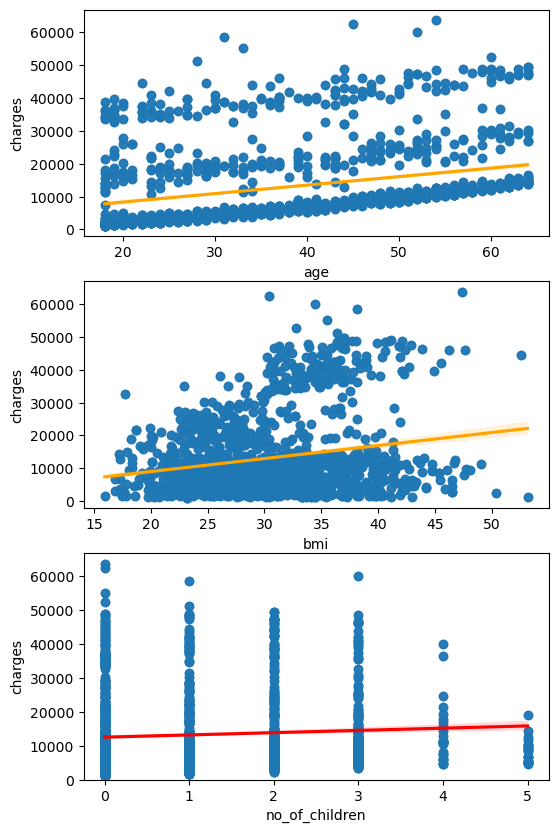

In [62]:
# we use regression plots on age, bmi, no_of_children
width = 6
height = 10
f, axes = plt.subplots(3, 1, figsize=(width, height))
sns.regplot(x="age", y="charges", data=df, line_kws={"color":"orange"}, ax = axes[0])
sns.regplot(x="bmi", y="charges", data=df, line_kws={"color":"orange"}, ax = axes[1])
sns.regplot(x="no_of_children", y="charges", data=df, line_kws={"color":"red"}, ax = axes[2])

plt.ylim(0,)

In the case of bmi and age, we can appreciate some correlation. Let's take a look at the pearson coefficient

In [ ]:
df[["age","bmi","no_of_children","charges"]].corr()
# we can see that no_of_children is too close to 0, so it cant be a good predictor
# in the case of age and bmi, there is a week correlation of 0.3 and 0.2 approx


,age,bmi,no_of_children,charges
age,1.000000,0.113048,0.037574,0.298624
bmi,0.113048,1.000000,-0.001492,0.199846
no_of_children,0.037574,-0.001492,1.000000,0.066442
charges,0.298624,0.199846,0.066442,1.000000


## Boxplot

(0.0, 66902.85800000001)

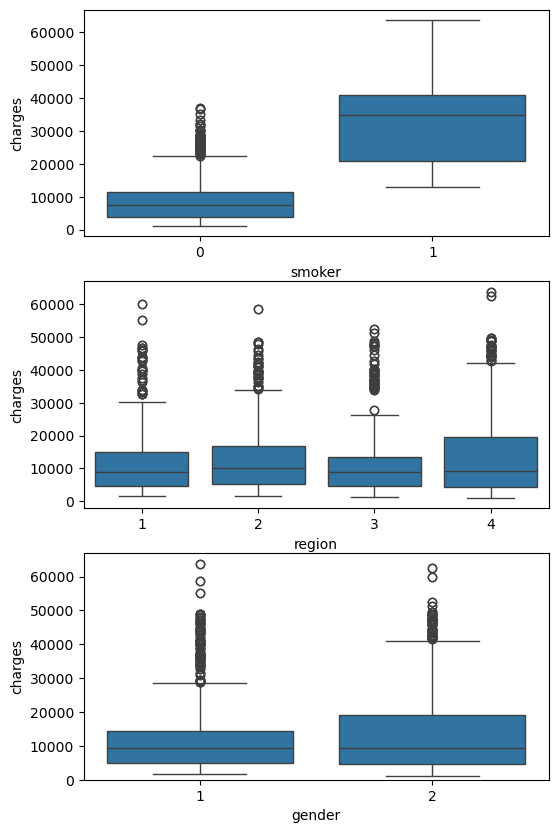

In [ ]:
# we use box plots for smoker, region and gender 
width = 6
height = 10
f, axes = plt.subplots(3, 1, figsize=(width, height))
sns.boxplot(x="smoker", y="charges", data=df, ax = axes[0])
sns.boxplot(x="region", y="charges", data=df, ax = axes[1])
sns.boxplot(x="gender", y="charges", data=df, ax = axes[2])

plt.ylim(0,)

# we can see in gender and region, a not appropriate distribution.
# just smoker can be a good predictor
# Let's take a look at the pearson coefficient

In [68]:
df[["smoker","region","gender","charges"]].corr()
# we can see that region and gender are too close to 0, so it cant be good predictors
# in the case of smoker, there is a quite strong correlation of 0.79 approx

,smoker,region,gender,charges
smoker,1.000000,0.054077,0.082326,0.788783
region,0.054077,1.000000,0.022213,0.054058
gender,0.082326,0.022213,1.000000,0.062837
charges,0.788783,0.054058,0.062837,1.000000


# Model Development

## Linear Regression

In [69]:
X = df[["smoker"]]
Y = df["charges"]

lm = LinearRegression()
lm.fit(X,Y)

print("intercept = ", lm.intercept_, "and coef: ", lm.coef_)
print("r2 score on training data=", lm.score(X,Y))

intercept =  8417.874393115962 and coef:  [23805.26542958]
r2 score on training data= 0.6221791733924185


$$
    Y = 8417.87 + 23805.27 * Smoker\\\
    \\\
    R^2 = 0.622
$$

<Axes: xlabel='smoker', ylabel='charges'>

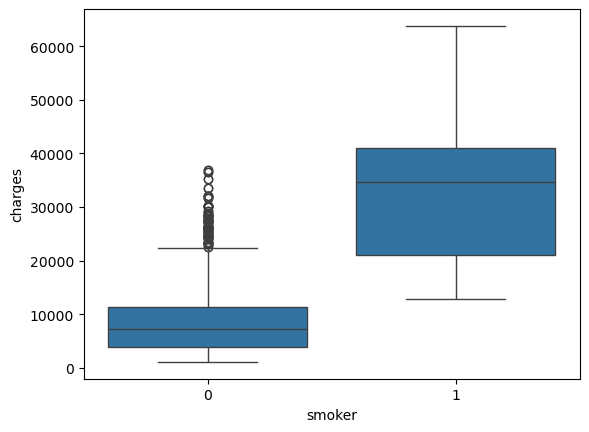

In [71]:
sns.boxplot(x="smoker", y="charges", data=df)

## Multiple Linear Regression

In [76]:
Z = df[["age","gender","bmi","no_of_children","smoker","region"]]
lm2 = LinearRegression()
lm2.fit(Z,Y)
print("intercept = ", lm2.intercept_, "and coef: ", lm2.coef_)
print("r2 score on training data=", lm2.score(Z,Y))

intercept =  -11335.504089794038 and coef:  [  255.67496013   -52.2547249    328.35529713   497.651344
 24001.46095435  -326.7228072 ]
r2 score on training data= 0.7504083820289634


$$
    Price = -11335.504 + 255.675 * Age - 52.255 * Gender + 328.355 * BMI \\\
    + 497.651 * NoOfChildren + 24001.461 * Smoker - 326.723 * Region
    \\\
    \\\
    R^2 = 0.750
$$

## Applying scaler and polynomial transformation with Pipeline

In [79]:
Input = [
    ("scale", StandardScaler()),
    ("polynomial", PolynomialFeatures(include_bias=False)), # degree 2 per default
    ("model", LinearRegression())
]

pipe = Pipeline(Input)
Z = df[["age","gender","bmi","no_of_children","smoker","region"]].astype(float)
pipe.fit(Z, Y)
ypipe = pipe.predict(Z)

print("intercept = ", pipe["model"].intercept_, "and coef: ", pipe["model"].coef_)
# 27 coefficients for
# a + b + c + d + e + f + 
# ab + ac + ad + ae + af + bc + bd + be + bf + cd + ce + cf + de + df + ef +
# a^2 + b^2 + c^2 + d^2 + e^2 + f^2
print("r2 score on training data=", r2_score(Y,ypipe))


intercept =  958679518483818.5 and coef:  [ 3.58184922e+03  1.72871858e+12  1.99107886e+03  9.95392822e+02
  1.50056582e+15 -3.58598305e+02  7.92095215e+02  1.48494154e+02
  4.91371765e+01 -4.66137695e+01 -3.20996475e+01  2.68168961e+02
  5.98938621e+13 -2.29204102e+01 -1.34441650e+02 -3.05420761e+01
  4.97186356e+01 -2.29366638e+02  5.35616608e+01  3.60247551e+03
 -2.80600800e+02 -1.87519394e+02 -1.60874344e+02 -2.14897644e+02
 -1.01857338e+15 -4.60626602e+01 -9.91822510e+01]
r2 score on training data= 0.8452562955462849


$$
    R^2 = 0.845
$$

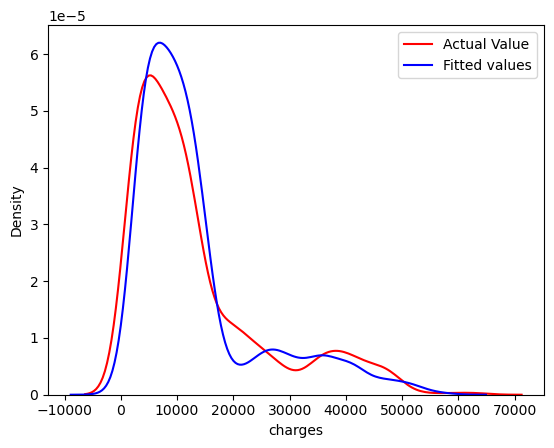

In [82]:
ax1 = sns.kdeplot(Y, color="r", label="Actual Value") 
sns.kdeplot(ypipe, color="b", label="Fitted values", ax=ax1)
plt.legend()

# Model Refinement

In [84]:
Z = df[["age","gender","bmi","no_of_children","smoker","region"]].astype(float)
Y = df["charges"]

# split 80 - 20
x_train, x_test, y_train, y_test = train_test_split(Z, Y, test_size=0.2, random_state=1)


# use a ridge regression model with an alpha of 0.1
RidgeModel = Ridge(alpha=0.1)
RidgeModel.fit(x_train, y_train)
yhat = RidgeModel.predict(x_test)
print("r2 score on test data: ", r2_score(y_test, yhat))


r2 score on test data:  0.6760807731582406


In [87]:
# apply polynomial transformation to the training parameters with degree=2
pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)

RidgePolyModel = Ridge(alpha=0.1)
RidgePolyModel.fit(x_train_pr, y_train)
y_hat = RidgePolyModel.predict(x_test_pr)

print("r2 score on training data: ", r2_score(y_train, RidgePolyModel.predict(x_train_pr)))
print("r2 score on test data: ", r2_score(y_test, y_hat))


r2 score on training data:  0.8581000569721151
r2 score on test data:  0.7835631107608061


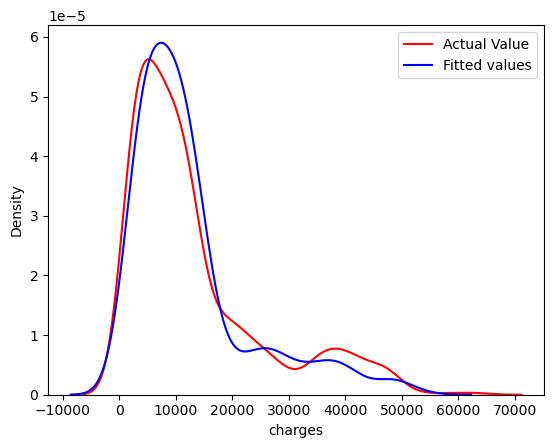

In [86]:
ax1 = sns.kdeplot(Y, color="r", label="Actual Value") 
sns.kdeplot(y_hat, color="b", label="Fitted values", ax=ax1)
plt.legend()